## Граф в PyG

В PyG графы описываются при помощи объекта класса `torch_geometric.data.Data`. 

Граф из коробки обычно содержит следующие атрибуты (однако они не являются обязательными; список атрибутов можно расширять):
* x - матрица атрибутов узлов размера [num_nodes, num_node_features];
* edge_index - информация о связях графа в формате COO размера [2, num_edges];
* edge_attr - матрица атрибутов связей размера [num_edges, num_edge_features];
* y - ответы для обучения (могут быть различной формы в зависимости от задачи);
* pos - матрица координат узлов размера [num_nodes, num_dims]

Кроме этого, объект класса `Data` имеет полезные свойства и методы: `num_nodes`, `num_edges`, `num_node_features`, `is_directed()` и т.д.

In [1]:
import torch
from torch_geometric.data import Data

Создадим следующий граф:

![](assets/01_graph.png)

In [2]:
# Создаем граф с 3 узлами и 4 связями
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
# Матрица фичей узлов
x = torch.tensor([[-1, 2], [0, 0], [1, -2]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
data

Data(x=[3, 2], edge_index=[2, 4])

Важно, чтобы `edge_index` был размерности [2, num_edges], а не [num_edges, 2]. Если используется второй вариант, то тензор с описанием ребер нужно предварительно транспонировать:

In [5]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1, 2], [0, 0], [1, -2]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index.T.contiguous())
data

Data(x=[3, 2], edge_index=[2, 4])

Как и DGL, PyG рассматривает все графы как ориентированные; неориентированный граф - частный случай ориентированного, в котором для каждого ребра существует обратное.

По объекту `Data` можно итерироваться следующим образом:

In [6]:
for key, item in data:
    print(f'{key=} {item=}')

key='x' item=tensor([[-1.,  2.],
        [ 0.,  0.],
        [ 1., -2.]])
key='edge_index' item=tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


Граф в PyG можно преобразовать в граф Networkx

In [ ]:
# TODO
# https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing


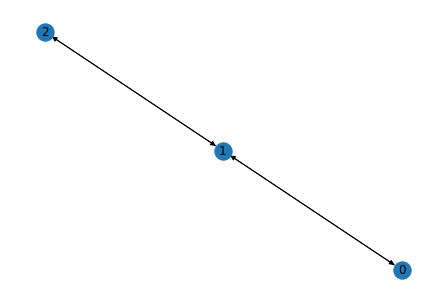

In [9]:
import networkx as nx
from torch_geometric.utils import to_networkx
G = to_networkx(data)
nx.draw(G, with_labels=True)

PyG содержит много популярных графовых датасетов. Каждый элемент датасета представляет из себя объект класса `Data`. Датасеты имеют специфичные атрибуты.

In [20]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='./tmp', use_node_attr=True, name='ENZYMES')
print(f'{type(dataset)=}',
      f'{len(dataset)=}',
      f'{dataset.num_classes=}',
      f'{dataset.num_node_features=}',
      f'{dataset[0]=}',
      sep='\n')

type(dataset)=<class 'torch_geometric.datasets.tu_dataset.TUDataset'>
len(dataset)=600
dataset.num_classes=6
dataset.num_node_features=21
dataset[0]=Data(edge_index=[2, 168], x=[37, 21], y=[1])


In [22]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./tmp', name='Cora')
print(f'{type(dataset)=}',
      f'{len(dataset)=}',
      f'{dataset.num_classes=}',
      f'{dataset.num_node_features=}',
      f'{dataset[0]=}',
      sep='\n')

type(dataset)=<class 'torch_geometric.datasets.planetoid.Planetoid'>
len(dataset)=1
dataset.num_classes=7
dataset.num_node_features=1433
dataset[0]=Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


## Пакеты графов в PyG

Для обучения моделей в мини-пакетном режиме, PyG предоставляет специальный DataLoader. Как и в DGL, пакет представляет из себя один большой граф с блочной матрицей смежности и объединенными матрицами атрибутов/меток.

![](assets/01_batch.png)

In [23]:
from torch_geometric.loader import DataLoader

In [32]:
dataset = TUDataset(root='./tmp', use_node_attr=True, name='ENZYMES')
loader = DataLoader(dataset, batch_size=32, shuffle=True)
batch = next(iter(loader))
print(f'{type(batch)=}',
      f'{batch.num_graphs=}',
      f'{batch=}',
      f'{batch.batch=}',
      sep='\n')

type(batch)=<class 'torch_geometric.data.batch.DataBatch'>
batch.num_graphs=32
batch=DataBatch(edge_index=[2, 4322], x=[1302, 21], y=[32], batch=[1302], ptr=[33])
batch.batch=tensor([ 0,  0,  0,  ..., 31, 31, 31])


## Преобразования в PyG

В PyG реализован набор преобразований, позволяющий модицицировать имеющиеся данные. Например, в датасете ShapeNet хранятся 17 тыс. облаков точек. При помощи преобразований можно превратить эти облака в графы.

Для примера берем случайно сгенерированное облако точек, чтобы не загружать весь датасет.

In [7]:
import torch as th
from torch_geometric.data import Data
cloud = Data(x=th.rand(2518, 3), 
             y=th.zeros(2518).bernoulli(0.8).long(), 
             pos=th.rand(2518, 3))

In [8]:
import torch_geometric.transforms as T

knn = T.KNNGraph(k=6)
print(f'{cloud=}', 
      f'{knn(cloud)=}',
      sep='\n')

cloud=Data(x=[2518, 3], y=[2518], pos=[2518, 3])
knn(cloud)=Data(x=[2518, 3], y=[2518], pos=[2518, 3], edge_index=[2, 15108])


In [9]:
print(f'{cloud.pos=}', 
      f'{T.RandomTranslate(10)(cloud).pos=}',
      sep='\n')

cloud.pos=tensor([[0.0654, 0.1714, 0.3693],
        [0.6080, 0.0078, 0.4653],
        [0.2825, 0.1490, 0.7878],
        ...,
        [0.7717, 0.6044, 0.6379],
        [0.1331, 0.5735, 0.8244],
        [0.6317, 0.4830, 0.7066]])
T.RandomTranslate(10)(cloud).pos=tensor([[-8.5747,  9.0654,  4.5878],
        [-0.9445,  5.7329, -8.9874],
        [ 0.7750,  0.0924,  7.1265],
        ...,
        [ 7.2462, 10.3662,  2.7344],
        [ 1.3126, -6.5712,  0.8780],
        [-3.6084, -3.0001, -1.1259]])


## Создание датасета

Для создания датасетов существуют два абстрактных класса: `Dataset` и `InMemoryDataset`. Второй вариант следует использовать, если датасет целиком влезает в память.

По аналогии с `torchvision` авторы PyG предлагают определять папки для хранения данных (`raw_dir` и `processed_dir`) и параметры для преобразований: `pre_transform` (используется перед сохранением данных на диск, удобно для тяжелых одноразовых операций), `transform` (используется для модификации данных перед их получением, удобно для аугментации).

Еще один параметр - `pre_filter` - нужен для опциональной фильтрации объектов перед сохранением на диск.

При создании `InMemoryDataset` нужно определить свойства и методы:
1. property: raw_file_names(): список файлов в `raw_dir`; если эти файлы есть, то пропускаем загрузку данных;
2. property: processed_file_names(): список файлов в `processed_dir`; если эти файлы есть, то пропускаем подготовку данных;
3. download(): для скачивания файлов в `raw_dir`;
4. process(): для преобразования данных и сохранения в `processed_dir`.

Если не определять `download()` или `process()`, то соответствующий шаг будет пропущен.

In [35]:
from torch_geometric.data import InMemoryDataset, Data
import networkx as nx
import numpy as np
import torch

class CustomKarateClub(InMemoryDataset):
    def __init__(self, root, transform=None):
        super().__init__(root, transform, None, None)
        self.data, self.slices = torch.load(self.processed_paths[0])

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

    @property
    def processed_file_names(self):
        return ['karate.pt']

    def process(self):
        G = nx.karate_club_graph()
        communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
        colors = np.zeros(G.number_of_nodes())
        for i, com in enumerate(communities):
            colors[list(com)] = i

        self.n_classes = np.unique(colors).shape[0]

        X = torch.eye(G.number_of_nodes()).float()
        y = torch.from_numpy(colors).long()

        adj = nx.to_scipy_sparse_array(G).tocoo()
        row = torch.from_numpy(adj.row).to(torch.long)
        col = torch.from_numpy(adj.col).to(torch.long)
        edge_index = torch.stack([row, col], dim=0)

        g = Data(x=X, y=y, edge_index=edge_index)

        data, slices = self.collate([g])
        torch.save((data, slices), self.processed_paths[0])

In [36]:
dataset = CustomKarateClub('./tmp')